In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
import cv2
import imghdr
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Rescaling


# Check if GPU is available
print(f'Tensorflow Version: {tf.__version__}')

SEED = 111

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams.update({'font.size': 12})

Tensorflow Version: 2.17.1


In [2]:
import os
import random
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

USER_PATH = "/kaggle/input/brain-tumors-dataset/Data"
batch_size = 32
image_dim = (168, 168)  # Adjust if needed
n_channels = 1  # Grayscale
num_classes = 4  # Normal and 3 Tumor types
SEED = 42  # Define a seed value for reproducibility

# Setting seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Class mappings
class_mappings = {
    'Normal': 0,
    'glioma_tumor': 1,
    'meningioma_tumor': 2,
    'pituitary_tumor': 3
}
inv_class_mappings = {}

for key, value in class_mappings.items():
    inv_class_mappings[value] = key
    
class_names = []

for key in class_mappings.keys():
    class_names.append(key)

# Function to get data paths and labels
def get_data_labels(data_path, random_state=SEED):
    image_paths = []
    labels = []

    # Handle 'Normal' class
    normal_folder = "/kaggle/input/brain-tumors-dataset/Data/Normal"
    for image_file in os.listdir(normal_folder):
        image_paths.append(os.path.join(normal_folder, image_file))
        labels.append(class_mappings['Normal'])

    # Handle tumor classes
    tumor_folder = "/kaggle/input/brain-tumors-dataset/Data/Tumor"
    for tumor_type in os.listdir(tumor_folder):  # Subfolders for each tumor type
        tumor_type_folder = os.path.join(tumor_folder, tumor_type)
        if os.path.isdir(tumor_type_folder):
            for image_file in os.listdir(tumor_type_folder):
                image_paths.append(os.path.join(tumor_type_folder, image_file))
                labels.append(class_mappings[tumor_type])

    # Shuffle the data
    combined = list(zip(image_paths, labels))
    random.Random(random_state).shuffle(combined)
    image_paths, labels = zip(*combined)
    return list(image_paths), list(labels)

# Getting all image paths and labels
all_paths, all_labels = get_data_labels(USER_PATH)

# Split into training (70%) and remaining 30% for validation and testing
train_paths, remaining_paths, train_labels, remaining_labels = train_test_split(
    all_paths, all_labels, test_size=0.3, random_state=SEED
)

# Split remaining 30% into 20% for validation and 10% for testing
val_paths, test_paths, val_labels, test_labels = train_test_split(
    remaining_paths, remaining_labels, test_size=0.33, random_state=SEED  # 10% of the total data
)

# Prepare datasets
def get_dataset(image_paths, labels, image_dim, n_channels, num_classes, batch_size):
    # Function to process an image
    def process_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=n_channels)
        image = tf.image.resize(image, image_dim)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize
        label = tf.one_hot(label, num_classes)  # Convert labels to one-hot
        return image, label

    # Convert data into a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(image_paths)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create training, validation, and testing datasets
train_ds = get_dataset(train_paths, train_labels, image_dim, n_channels, num_classes, batch_size)
val_ds = get_dataset(val_paths, val_labels, image_dim, n_channels, num_classes, batch_size)
test_ds = get_dataset(test_paths, test_labels, image_dim, n_channels, num_classes, batch_size)

# Output dataset details
print(f"Training dataset: {len(train_paths)} images")
print(f"Validation dataset: {len(val_paths)} images")
print(f"Testing dataset: {len(test_paths)} images")


Training dataset: 15170 images
Validation dataset: 4356 images
Testing dataset: 2146 images


In [3]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [4]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()

images = batch[0]
images.min(), images.max()

(0.0, 1.0)

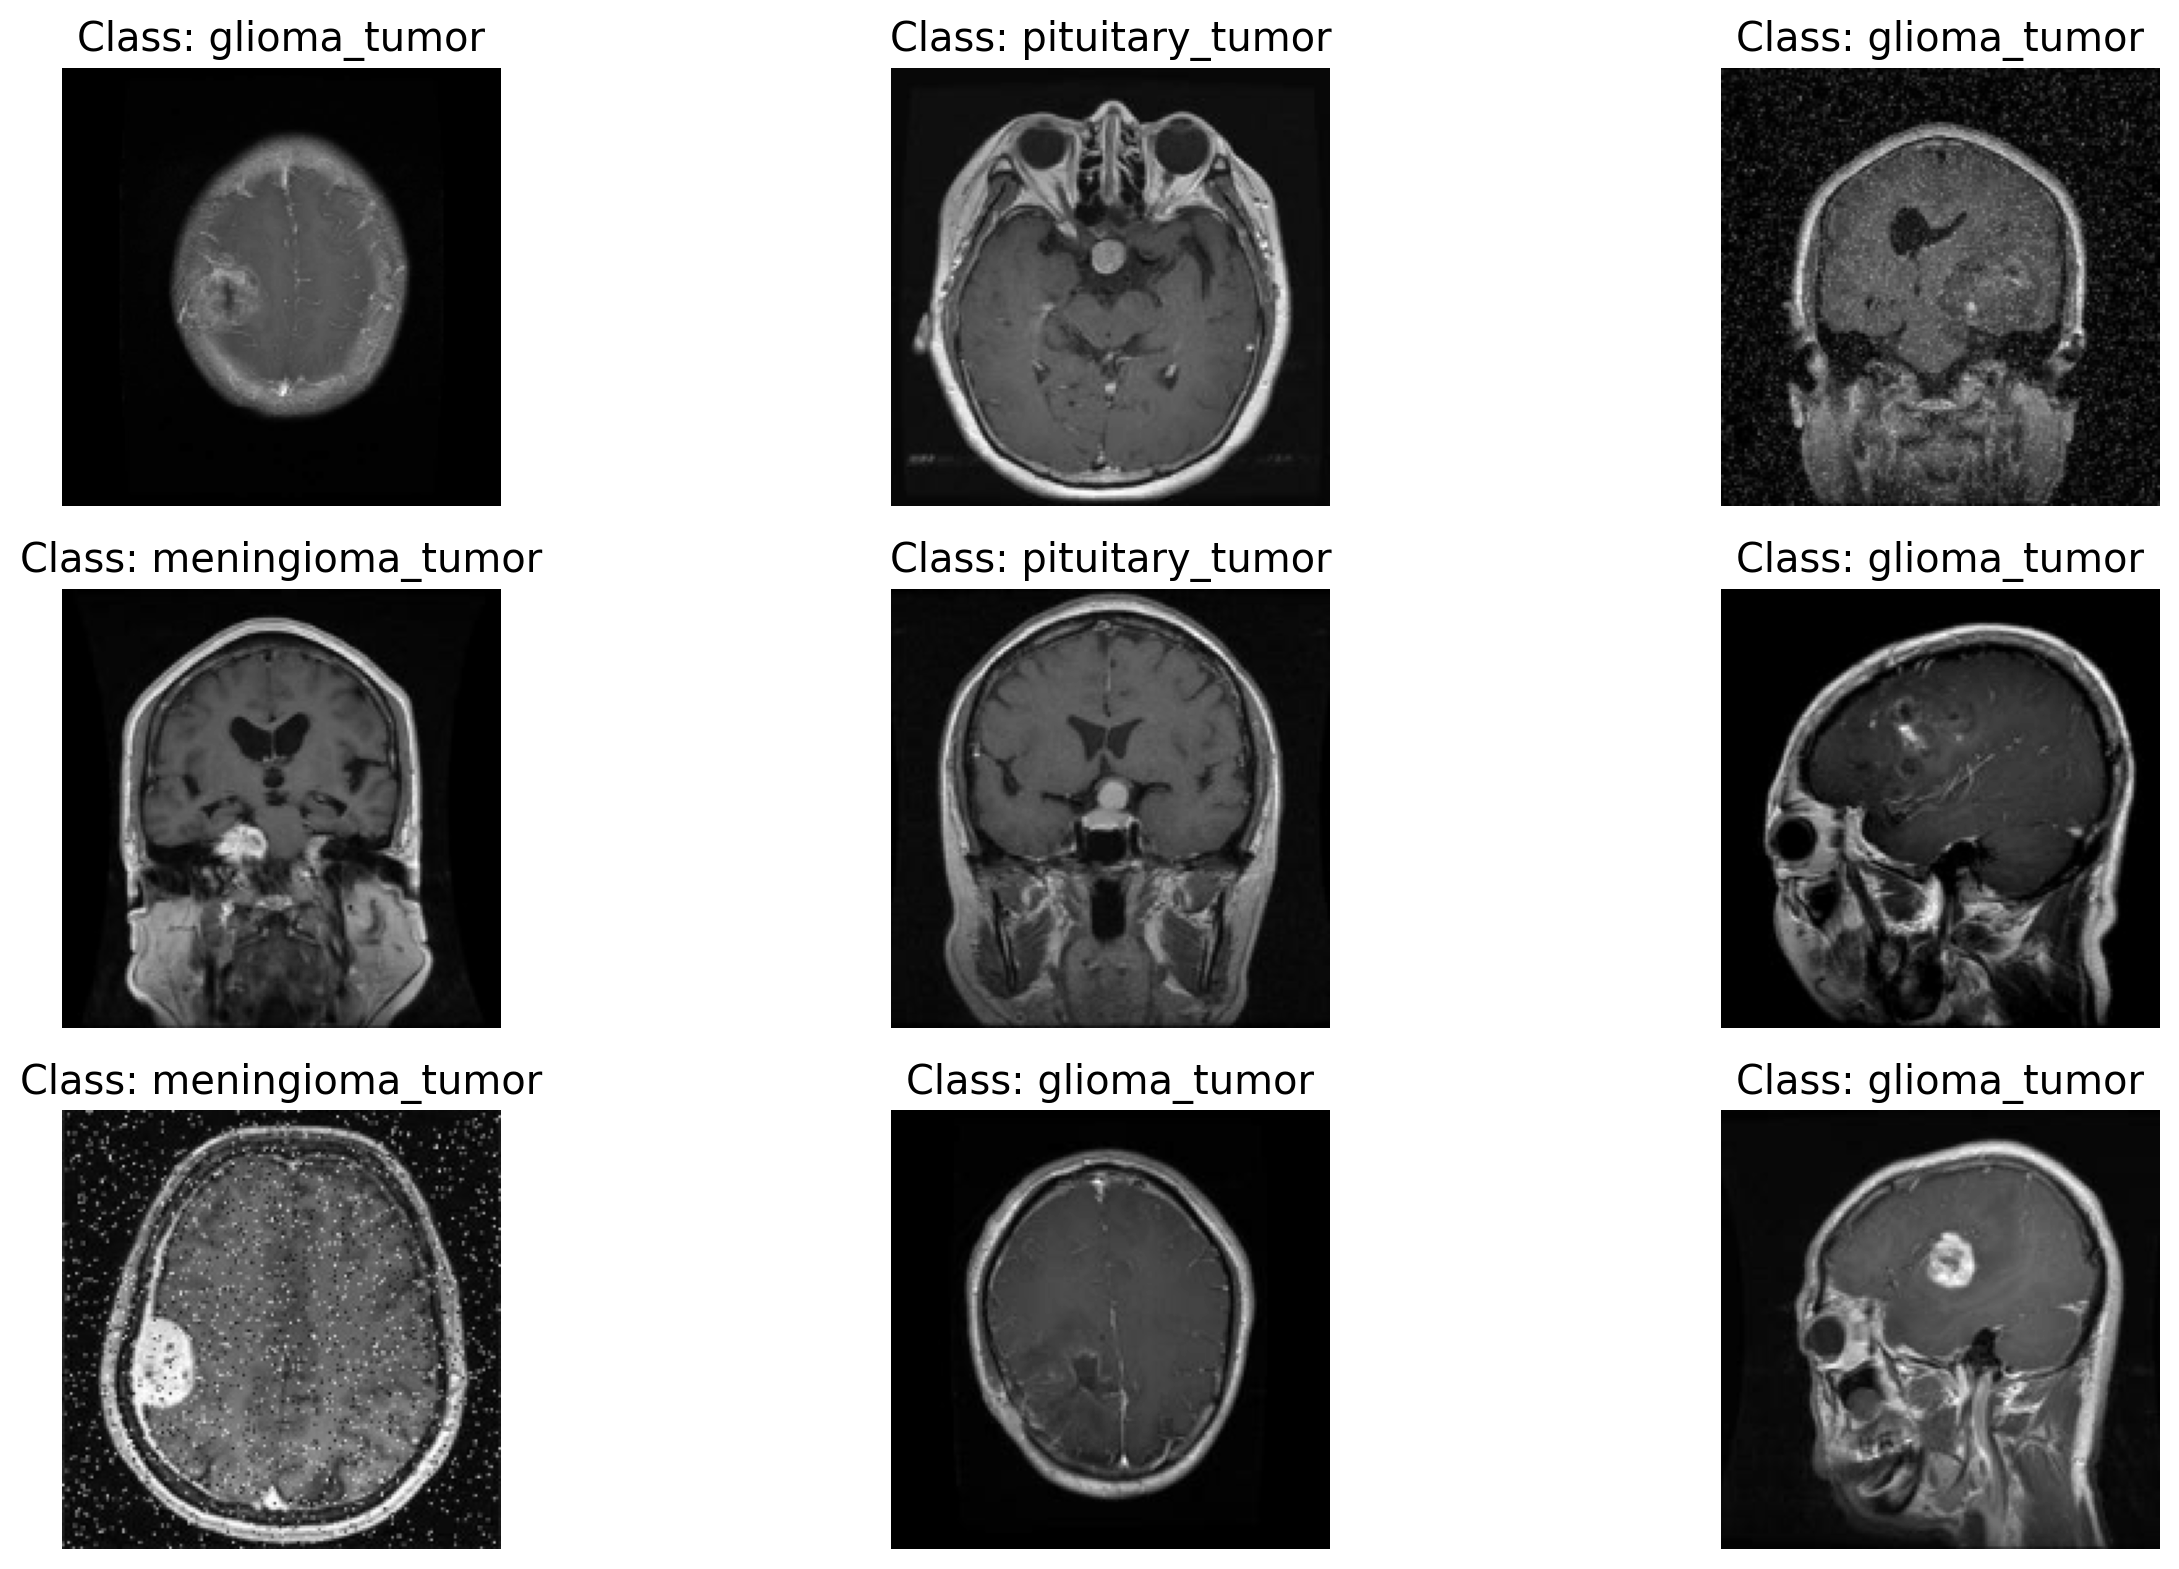

In [5]:
import matplotlib.pyplot as plt

# Number of samples to visualize
n_samples = 9

# Get one batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure()
    
    # Loop through the first `n_samples` in the batch
    for i in range(n_samples):
        label_index = tf.argmax(labels[i]).numpy()  # Convert one-hot label to integer
        
        plt.subplot(3, 3, i + 1)  # Create a subplot for each image
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # Display grayscale image
        plt.title(f"Class: {class_names[label_index]}")  # Show class name
        plt.axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
from tensorflow.keras import layers, models, regularizers

inputs = layers.Input(shape=(168, 168, 1))

# Block 1
x = layers.Conv2D(32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.005))(inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Conv2D(32, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SpatialDropout2D(0.3)(x)

# Block 2
shortcut = layers.Conv2D(64, kernel_size=1, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Conv2D(64, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.add([x, shortcut])
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SpatialDropout2D(0.4)(x)

# Block 3
shortcut = layers.Conv2D(128, kernel_size=1, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.add([x, shortcut])
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SpatialDropout2D(0.4)(x)

# Block 4
shortcut = layers.Conv2D(256, kernel_size=1, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.add([x, shortcut])
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.SpatialDropout2D(0.4)(x)

# Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(4, activation='softmax')(x)  # Changed to 4 classes with softmax

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [9]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

In [12]:
import numpy as np
from sklearn.utils import class_weight

# Assuming train_labels contains integer class labels (0, 1, 2, 3)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2, 3]),  # Explicitly specifying the classes
    y=train_labels
)

# Convert the class weights to a dictionary
class_weights_dict = {i: class_weights[i] for i in range(4)}  # Adjusted for 4 classes
print("Calculated class weights:", class_weights_dict)


Calculated class weights: {0: 1.79399243140965, 1: 0.859392703376388, 2: 0.8403500997119433, 3: 0.9182808716707022}


In [13]:
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 168, 168, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 168, 168, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 168, 168, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 168, 168, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 168, 168, 32)   │          9,248 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 168, 168, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 168, 168, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 84, 84, 32)     │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 84, 84, 32)     │              0 │ max_pooling2d[0][0]    │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 42, 42, 64)     │         18,496 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 42, 42, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 42, 42, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 42, 42, 64)     │         36,928 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 42, 42, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 42, 42, 64)     │          2,112 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 42, 42, 64)     │              0 │ batch_normalization_3… │
│                           │                        │                │ conv2d_2[0][0]         │
├──────────────────────

 Total params: 1,220,004 (4.65 MB)

 Trainable params: 1,218,084 (4.65 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [14]:
history = model.fit(
    train_ds,
    epochs=125,
    validation_data=val_ds,  # Use the validation set, not the test set
    callbacks=[model_rlr, model_mc],
    verbose=True,
    class_weight=class_weights_dict
)

Epoch 1/125
475/475 ━━━━━━━━━━━━━━━━━━━━ 78s 106ms/step - accuracy: 0.3788 - loss: 7.2797 - val_accuracy: 0.3939 - val_loss: 5.9085 - learning_rate: 3.0000e-04
Epoch 2/125
475/475 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - accuracy: 0.5641 - loss: 5.2846 - val_accuracy: 0.5693 - val_loss: 4.5411 - learning_rate: 3.0000e-04
Epoch 3/125
475/475 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.6319 - loss: 4.1015 - val_accuracy: 0.6501 - val_loss: 3.4486 - learning_rate: 3.0000e-04
Epoch 4/125
475/475 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.6776 - loss: 3.1693 - val_accuracy: 0.6811 - val_loss: 2.6623 - learning_rate: 3.0000e-04
Epoch 5/125
475/475 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.7205 - loss: 2.4452 - val_accuracy: 0.7172 - val_loss: 2.0876 - learning_rate: 3.0000e-04
Epoch 6/125
475/475 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.7588 - loss: 1.9083 - val_accuracy: 0.8010 - val_loss: 1.5967 - learning_rate: 3.0000e-04
Epoch 7/125
475/475 ━━━━━━━━━━━━━━━━━━━━ 27s 

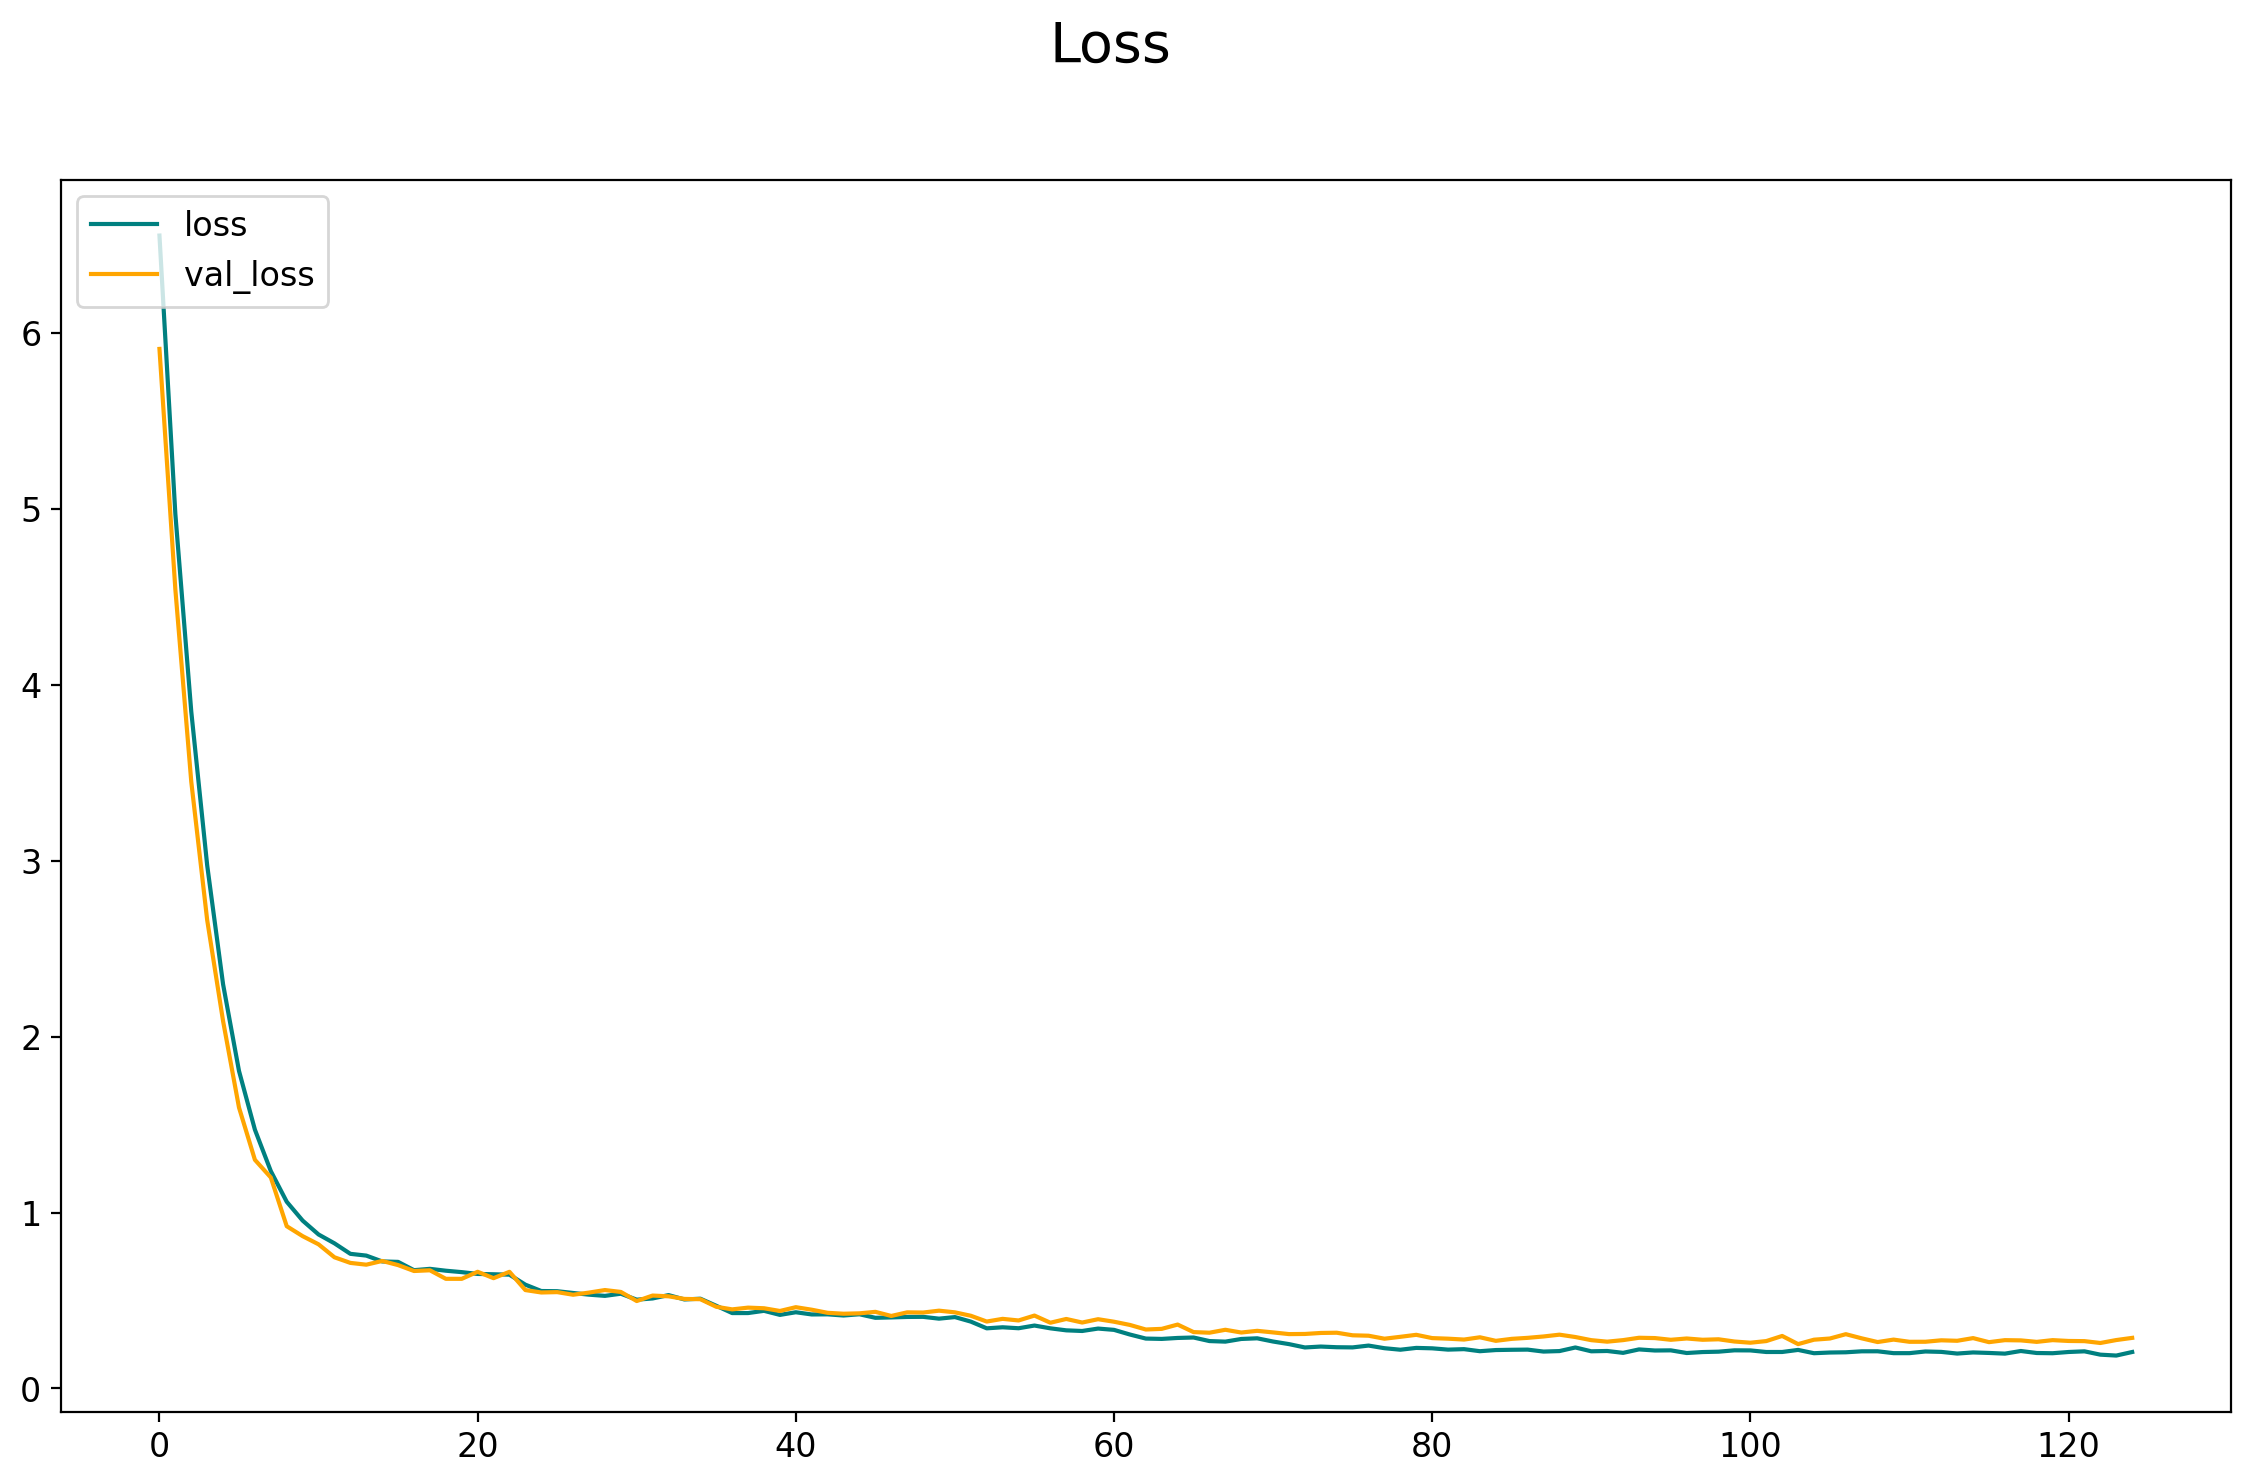

In [15]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

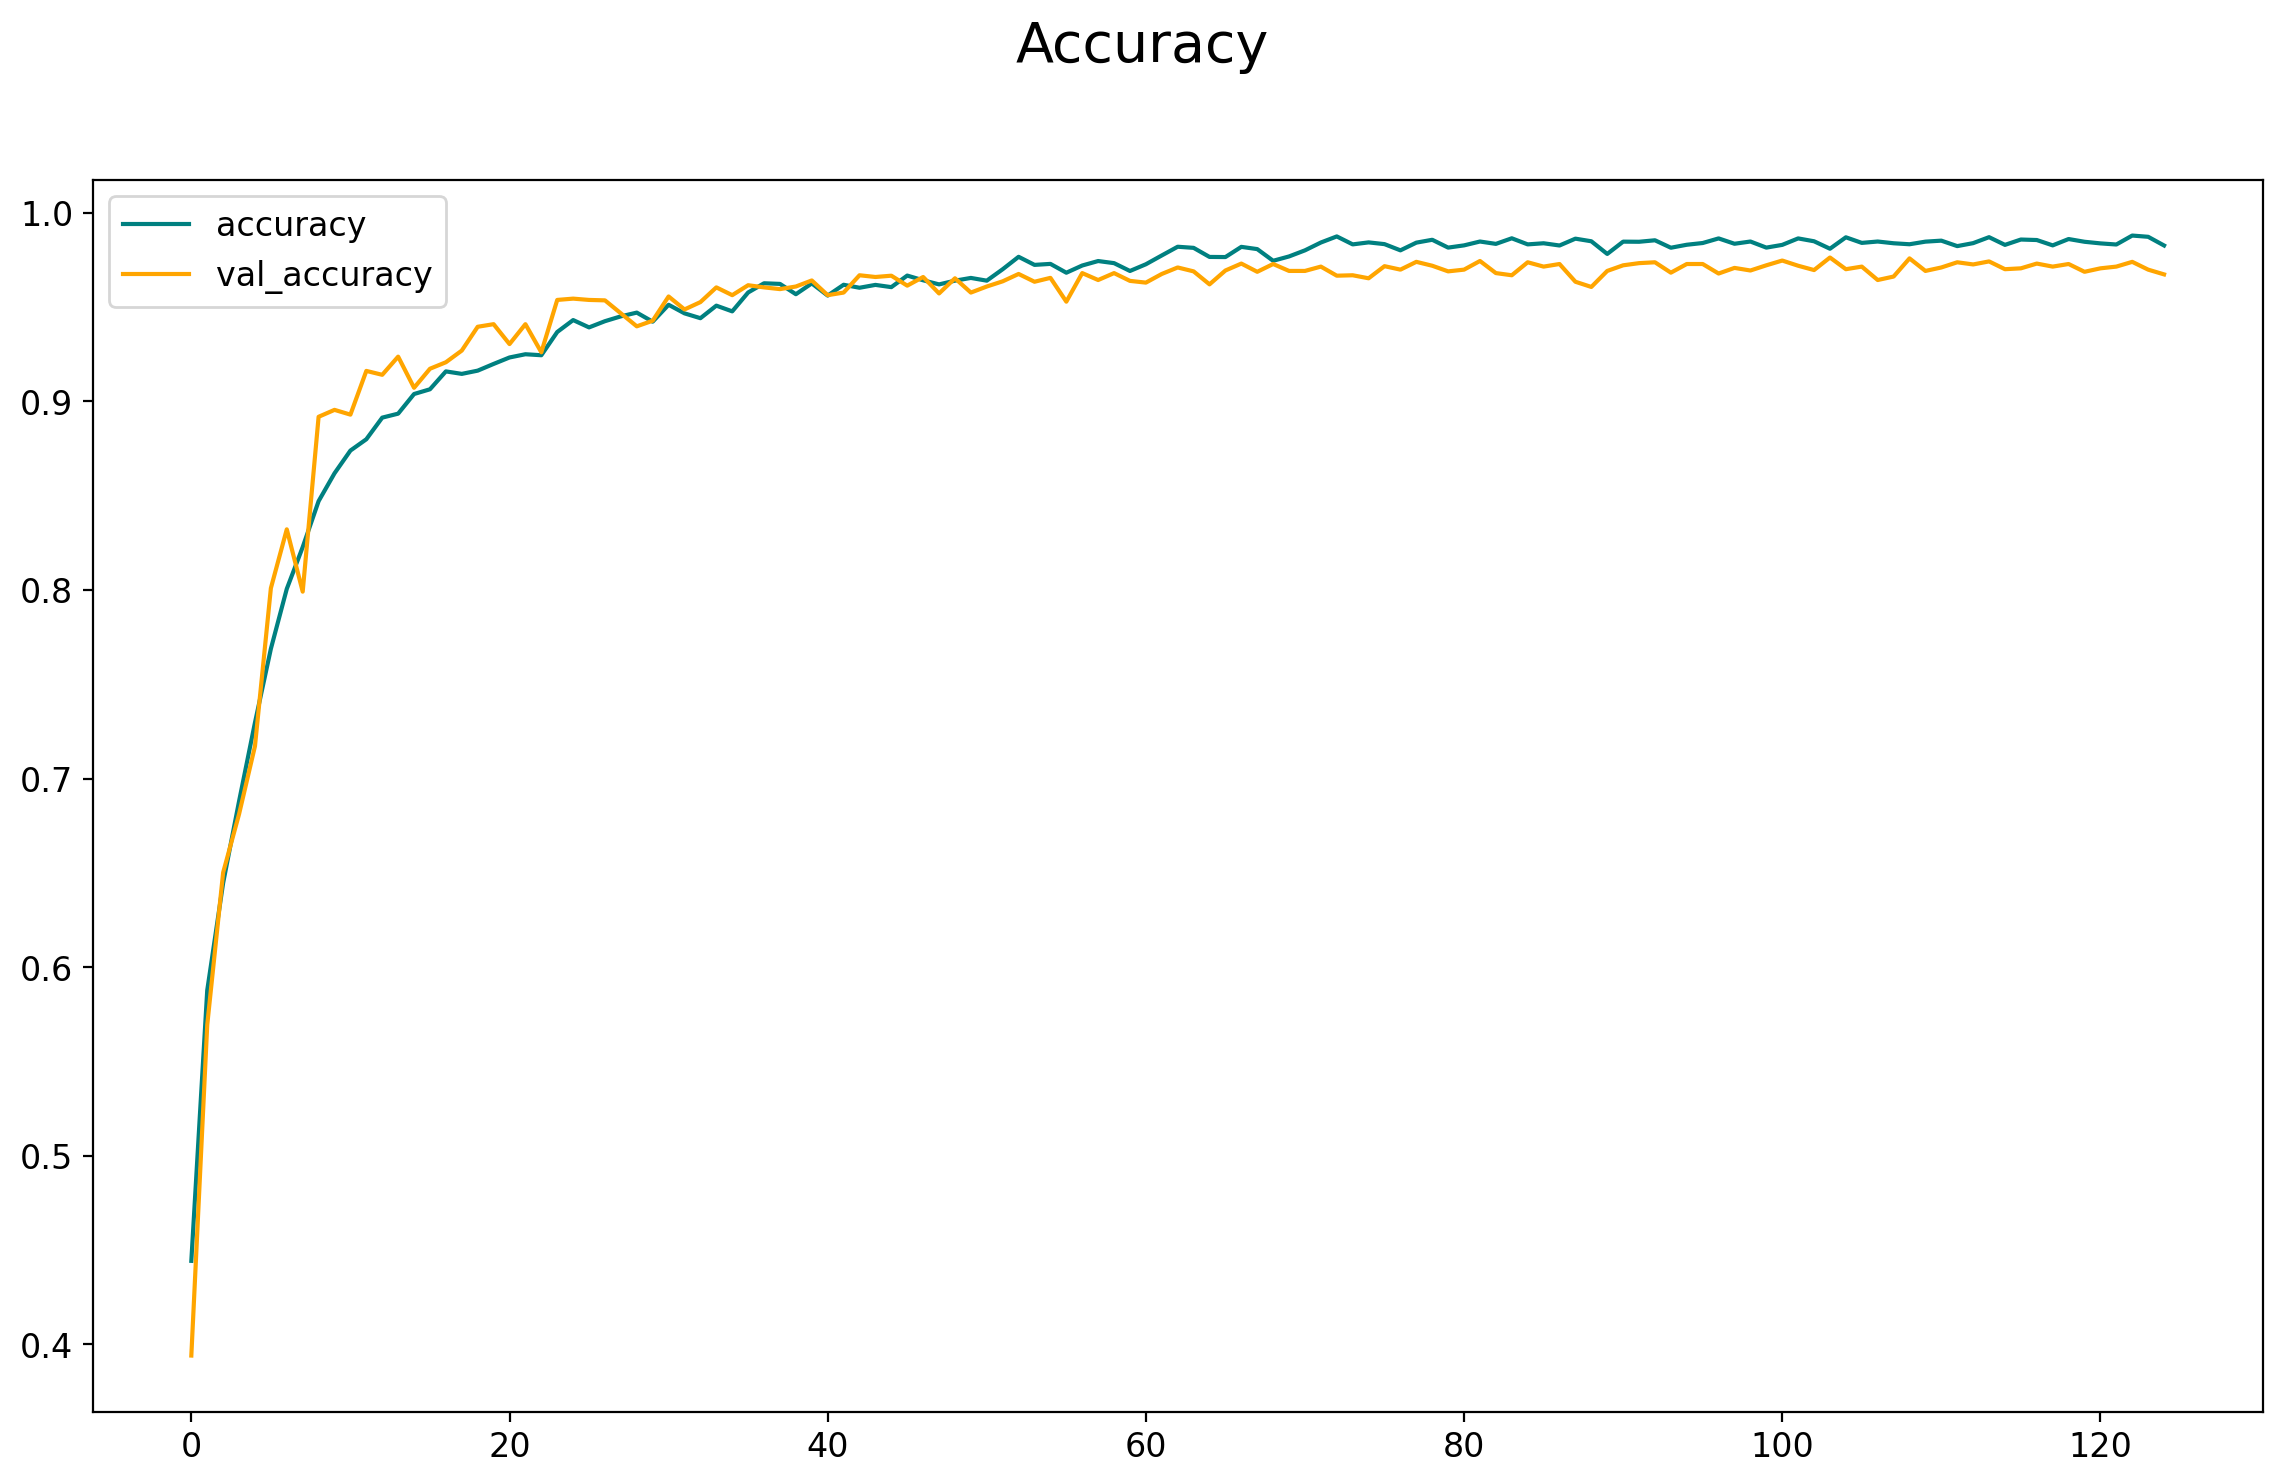

In [16]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [52]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 168, 168, 1)
(32, 4)


In [17]:
# Loading saved model
model = load_model('/kaggle/working/model.keras')

# Evaluate model and test data accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc*100:0.4f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9823 - loss: 0.2328
Test accuracy: 97.8565%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

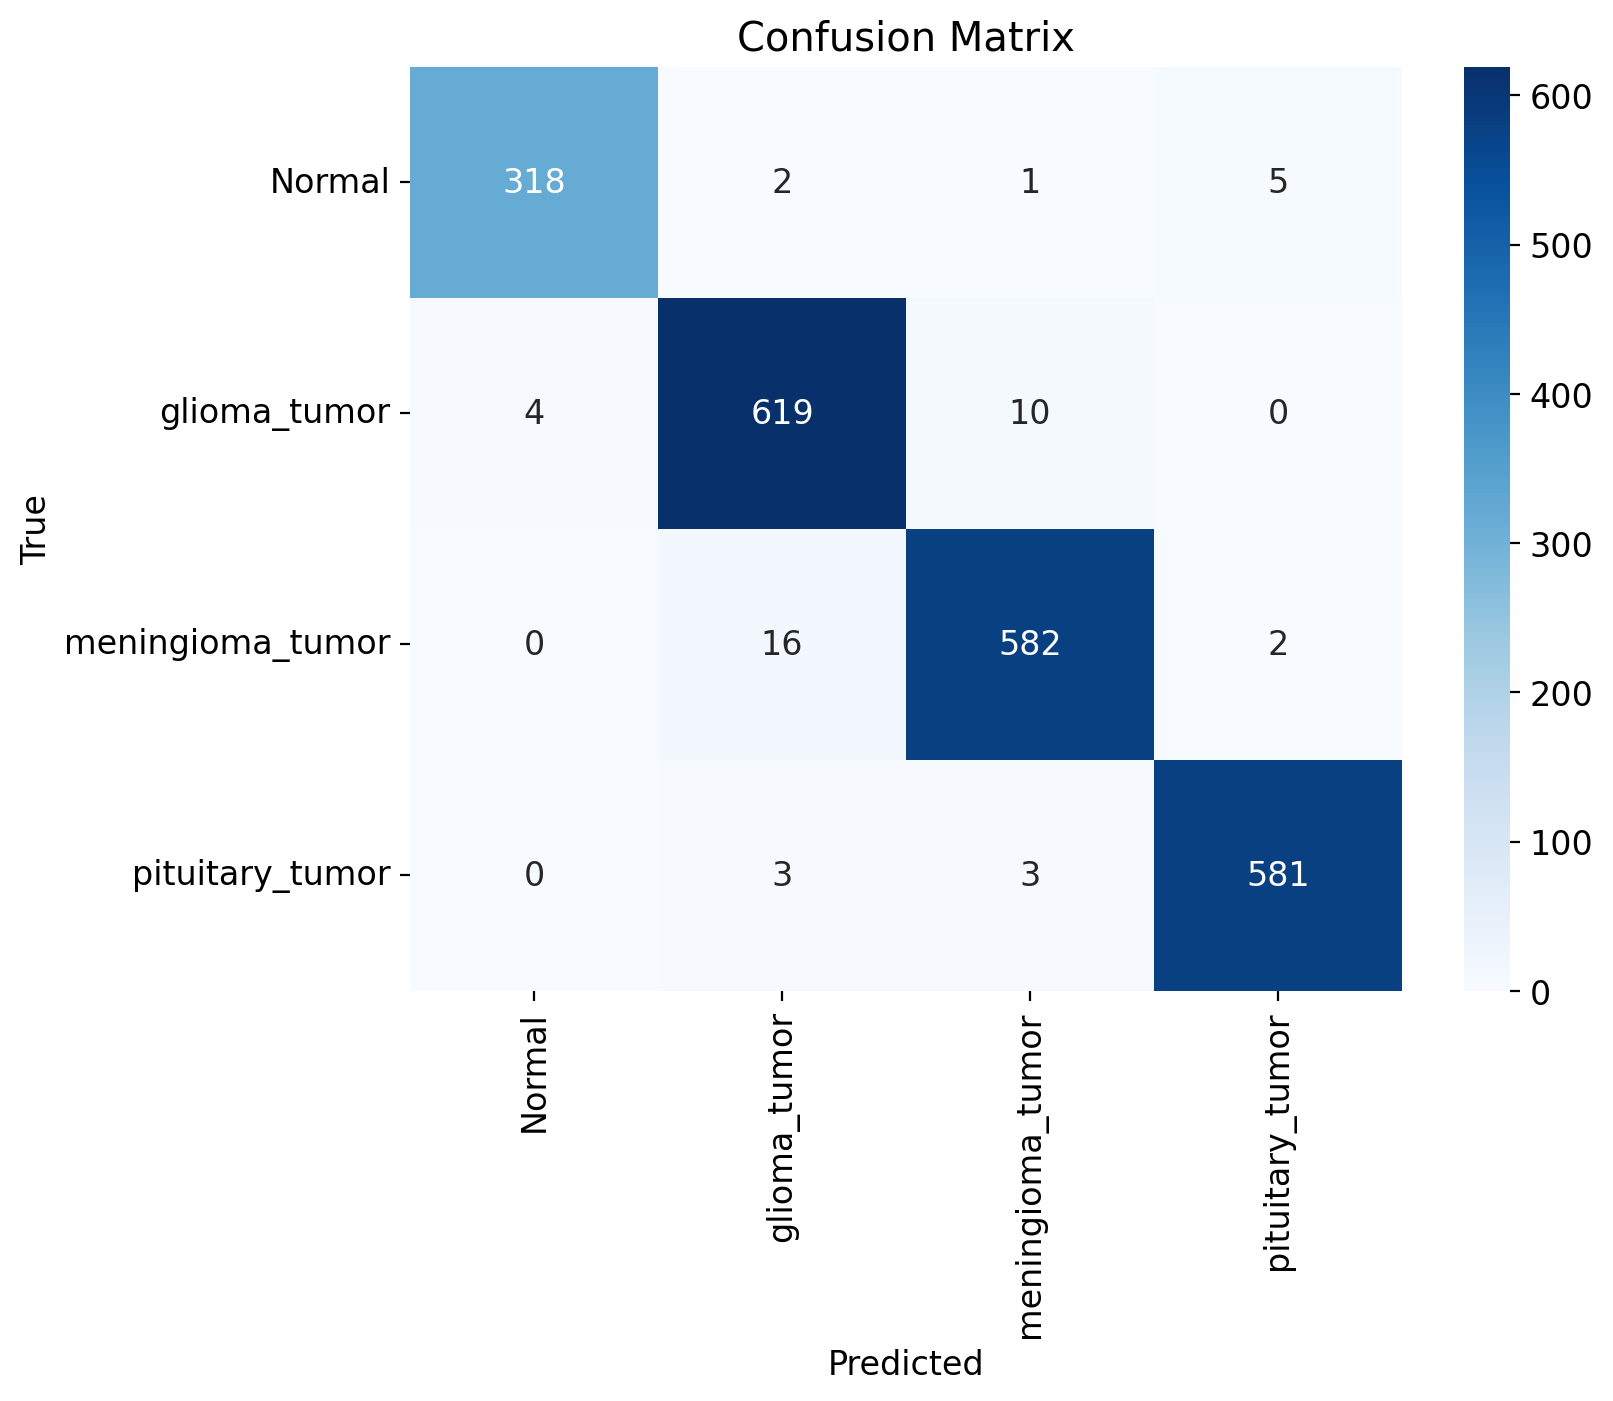

Classification Report:
                   precision    recall  f1-score   support

          Normal       0.99      0.98      0.98       326
    glioma_tumor       0.97      0.98      0.97       633
meningioma_tumor       0.98      0.97      0.97       600
 pituitary_tumor       0.99      0.99      0.99       587

        accuracy                           0.98      2146
       macro avg       0.98      0.98      0.98      2146
    weighted avg       0.98      0.98      0.98      2146

Precision: 97.86%
Recall: 97.86%
F1-Score: 97.86%


In [19]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Get the true labels and predictions
y_true = []
y_pred = []

# Iterate through the test dataset
for images, labels in test_ds:
    # Predict class probabilities and get the index of the highest value (class with the most probability)
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=-1))  # True labels
    y_pred.extend(np.argmax(predictions, axis=-1))  # Predicted labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)

# Additional Metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision*100:0.2f}%")
print(f"Recall: {recall*100:0.2f}%")
print(f"F1-Score: {f1*100:0.2f}%")


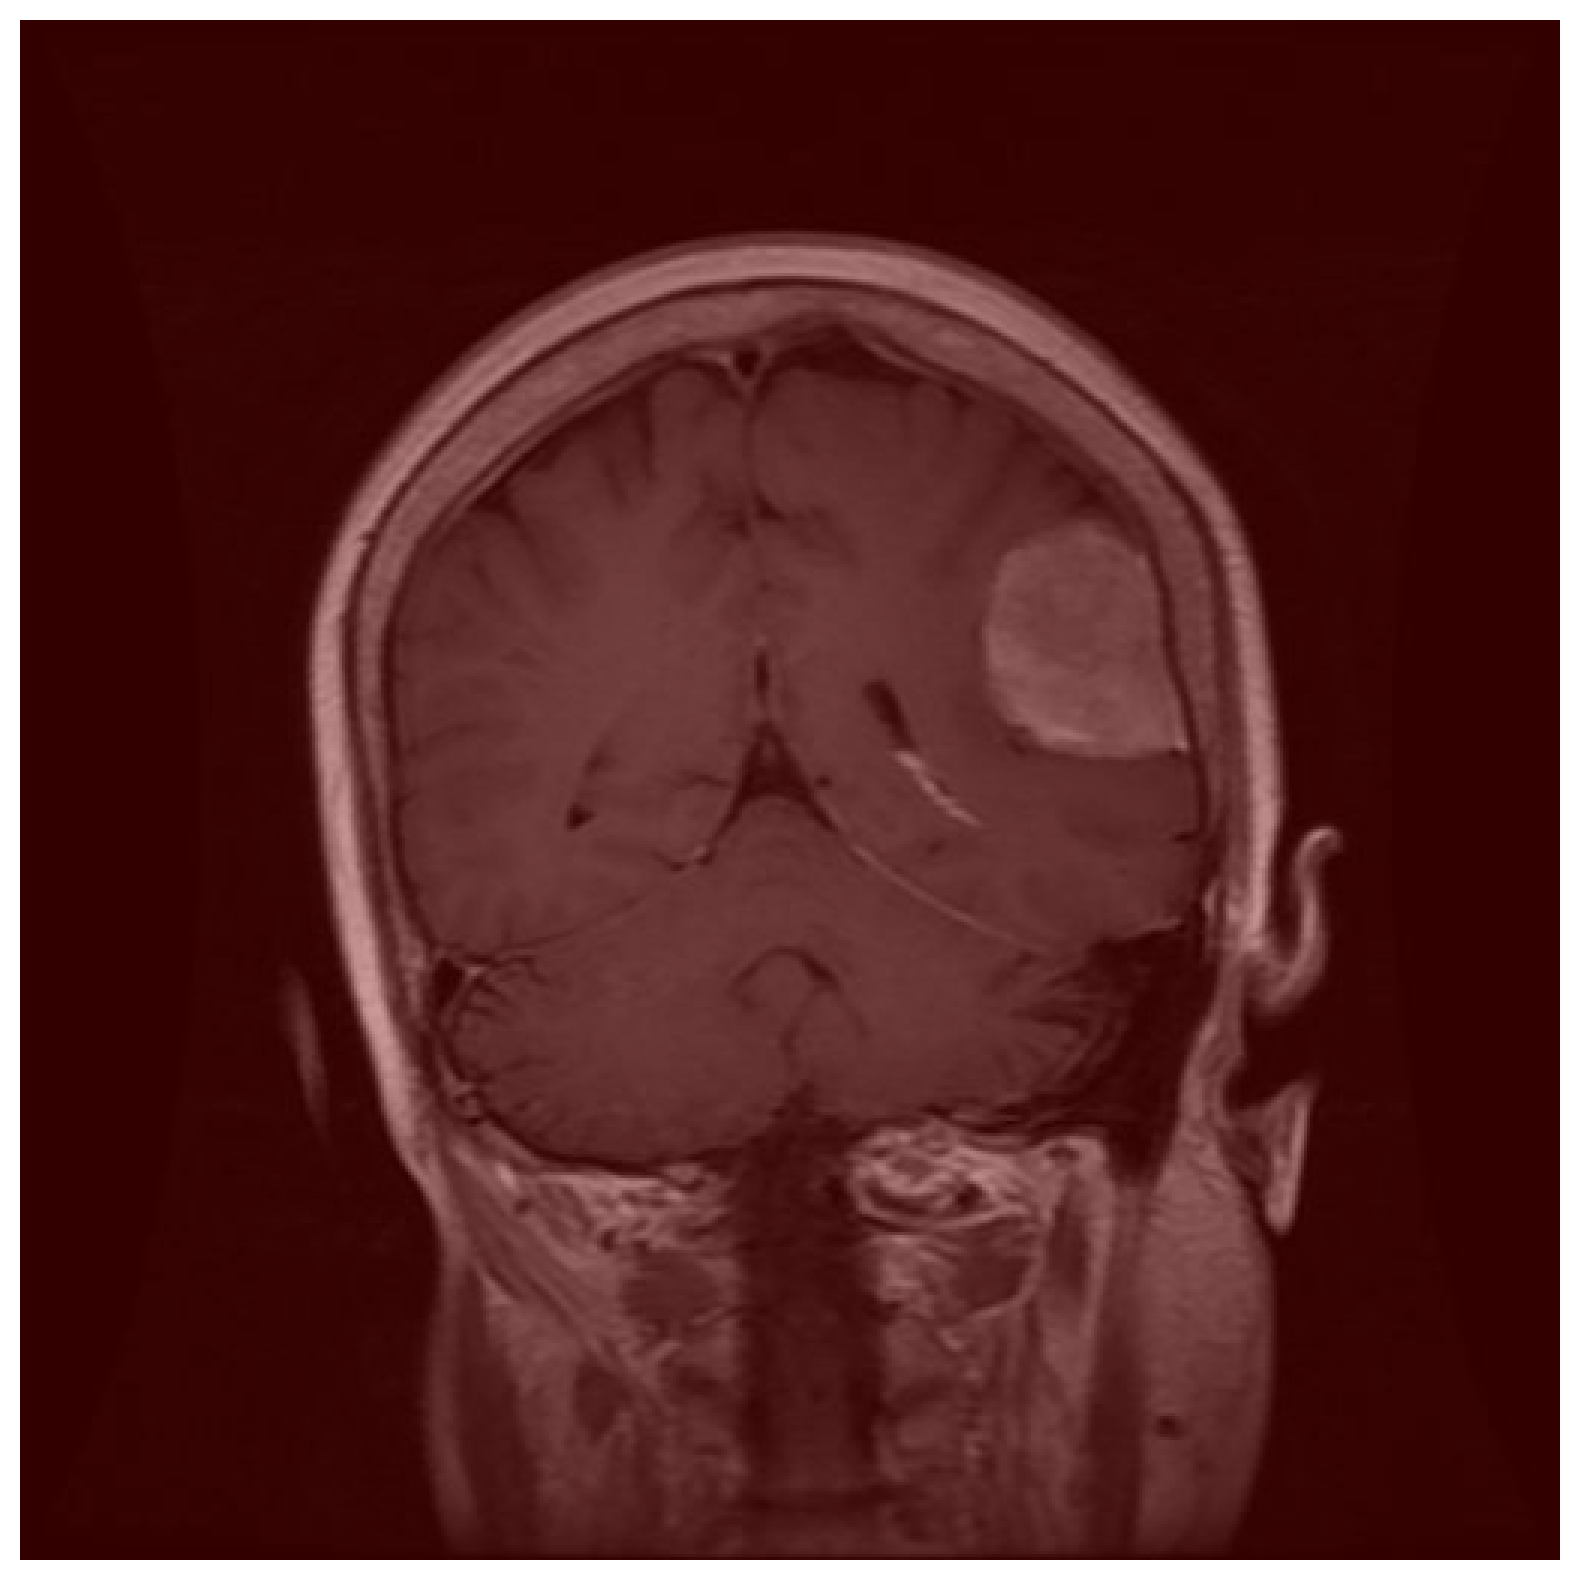

In [82]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2


# Function to load and preprocess an image
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (168, 168))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Grad-CAM function
def get_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.reduce_sum(last_conv_layer_output * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display Grad-CAM
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Path to an image in your dataset
image_path = '/kaggle/input/brain-tumors-dataset/Data/Tumor/meningioma_tumor/M_100.jpg'

# Load and preprocess the image
img_array = load_image(image_path)

# Get the last convolutional layer name
last_conv_layer_name = 'conv2d_8'  # Replace with actual last conv layer name

# Generate Grad-CAM heatmap
heatmap = get_gradcam(model, img_array, last_conv_layer_name)

# Display Grad-CAM
display_gradcam(image_path, heatmap)


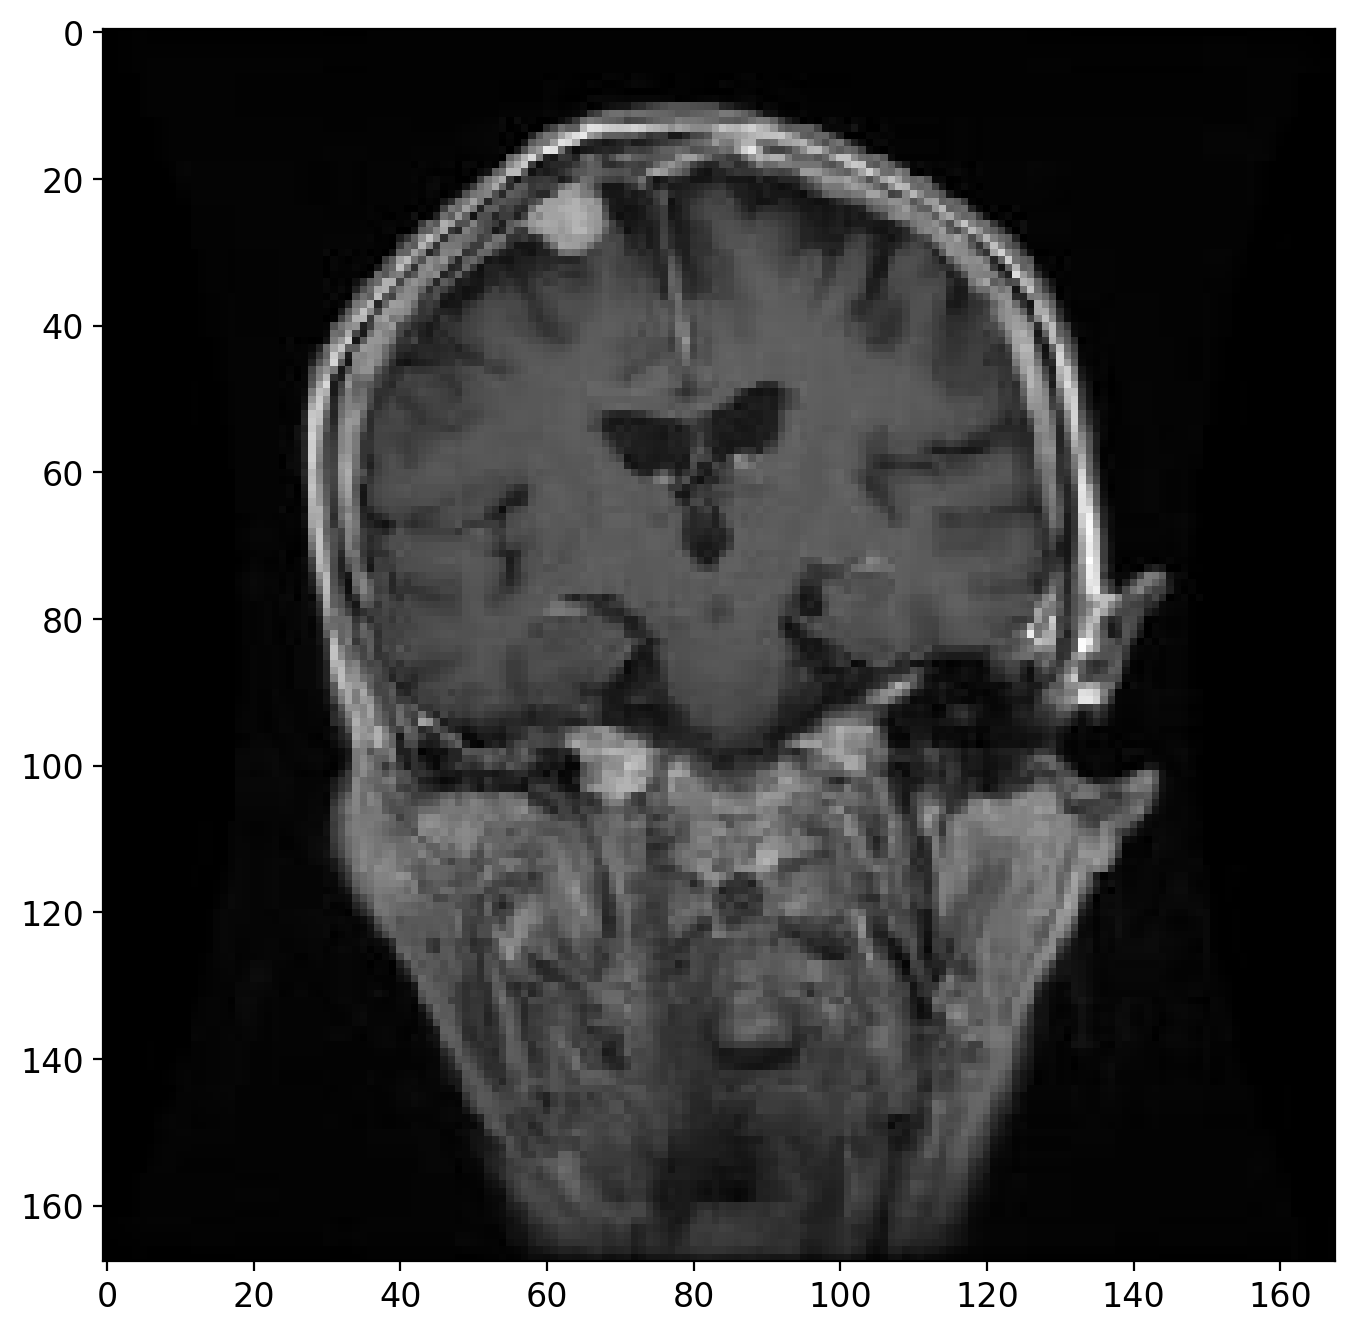

In [123]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the image as RGB
image = load_img("/kaggle/input/brain-tumors-dataset/Data/Tumor/meningioma_tumor/M_105_HF_.jpg", 
                 target_size=(168, 168))

# Convert to NumPy array
image = np.array(image)

# Convert to grayscale if needed
image = tf.image.rgb_to_grayscale(image)

# Convert to float and normalize
image = tf.cast(image, dtype=tf.float32) / 255.0

# Ensure batch dimension
inputs = image[np.newaxis, ...]

plt.imshow(image.numpy().squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
plt.show()


In [124]:
last_conv_layer = model.get_layer("conv2d_8")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [125]:
for layer in model.layers:
    print(layer.name)


input_layer
conv2d
batch_normalization
leaky_re_lu
conv2d_1
batch_normalization_1
leaky_re_lu_1
max_pooling2d
spatial_dropout2d
conv2d_3
batch_normalization_2
leaky_re_lu_2
conv2d_4
batch_normalization_3
conv2d_2
add
leaky_re_lu_3
max_pooling2d_1
spatial_dropout2d_1
conv2d_6
batch_normalization_4
leaky_re_lu_4
conv2d_7
batch_normalization_5
conv2d_5
add_1
leaky_re_lu_5
max_pooling2d_2
spatial_dropout2d_2
conv2d_9
batch_normalization_6
leaky_re_lu_6
conv2d_10
batch_normalization_7
conv2d_8
add_2
leaky_re_lu_7
max_pooling2d_3
spatial_dropout2d_3
global_average_pooling2d
dense


In [126]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["global_average_pooling2d", "dense"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [127]:
print(model.input_shape)

(None, 168, 168, 1)


In [128]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [129]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [130]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [131]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [132]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (168, 168))

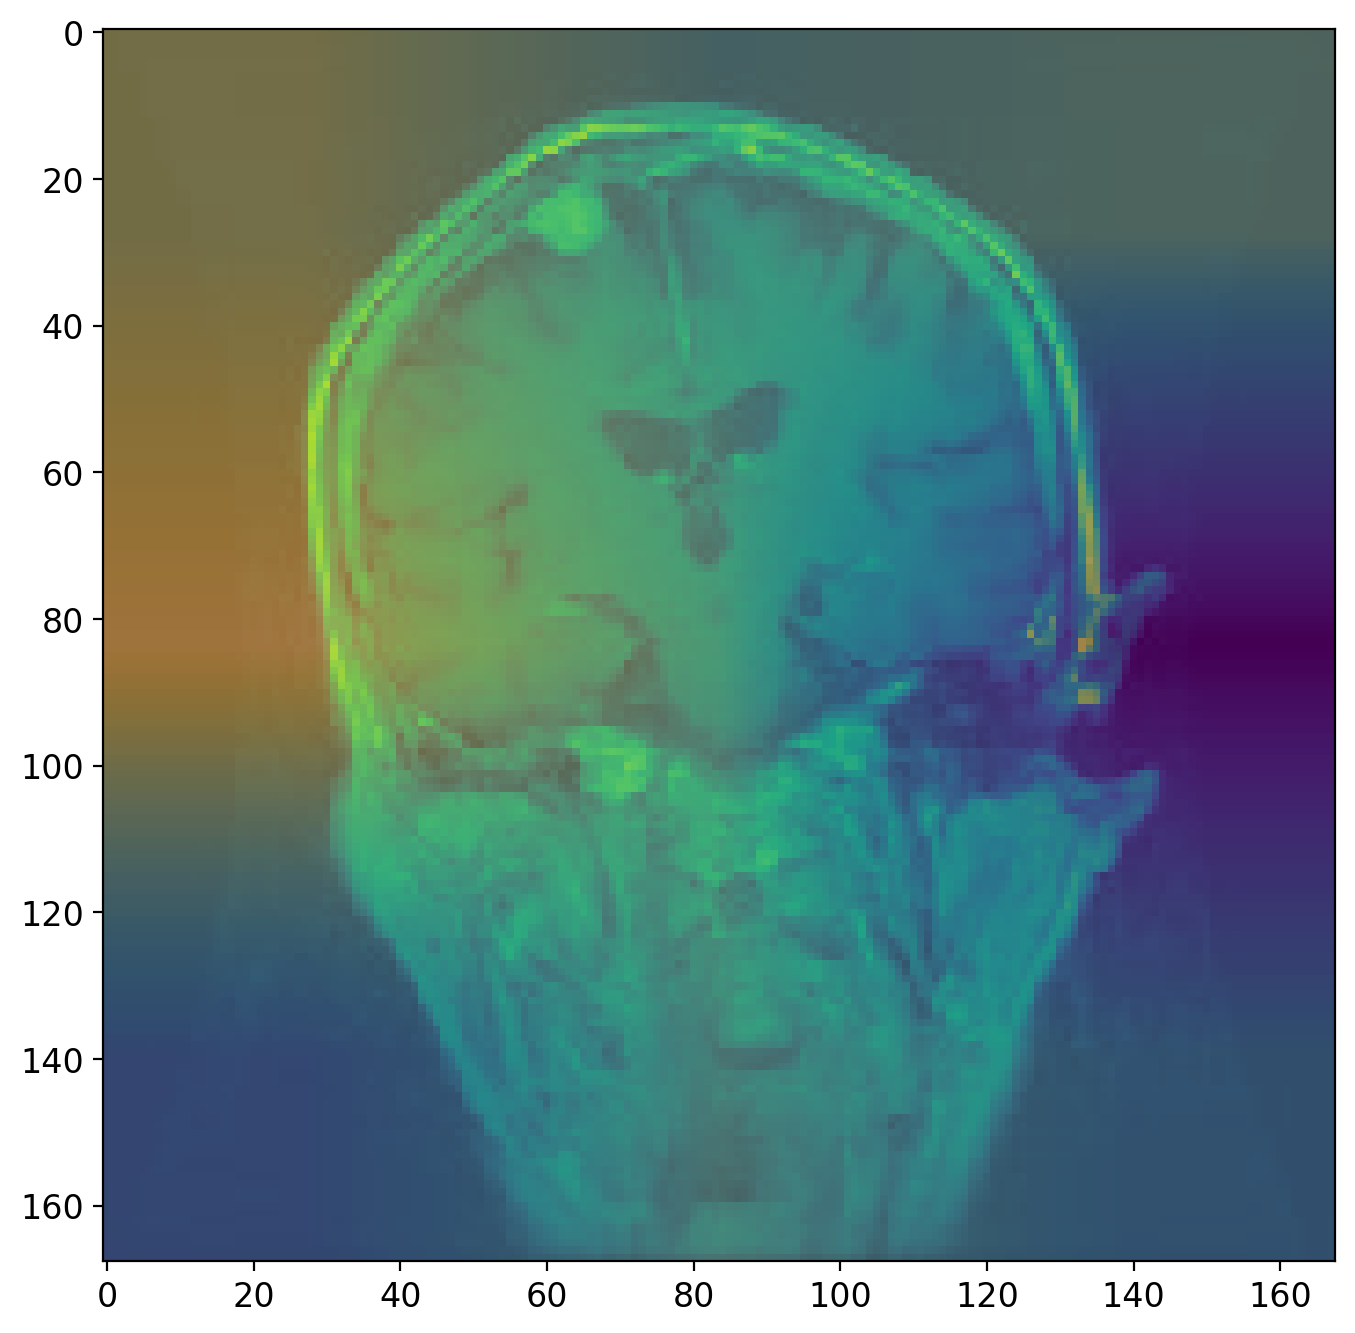

In [133]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.5)

In [134]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [135]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]

In [136]:
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)

In [137]:
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

In [138]:
for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]

In [139]:
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (168, 168))

In [140]:
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)

<ipython-input-140-3b18d28bbf8d>:2: RuntimeWarning: invalid value encountered in divide
  guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (


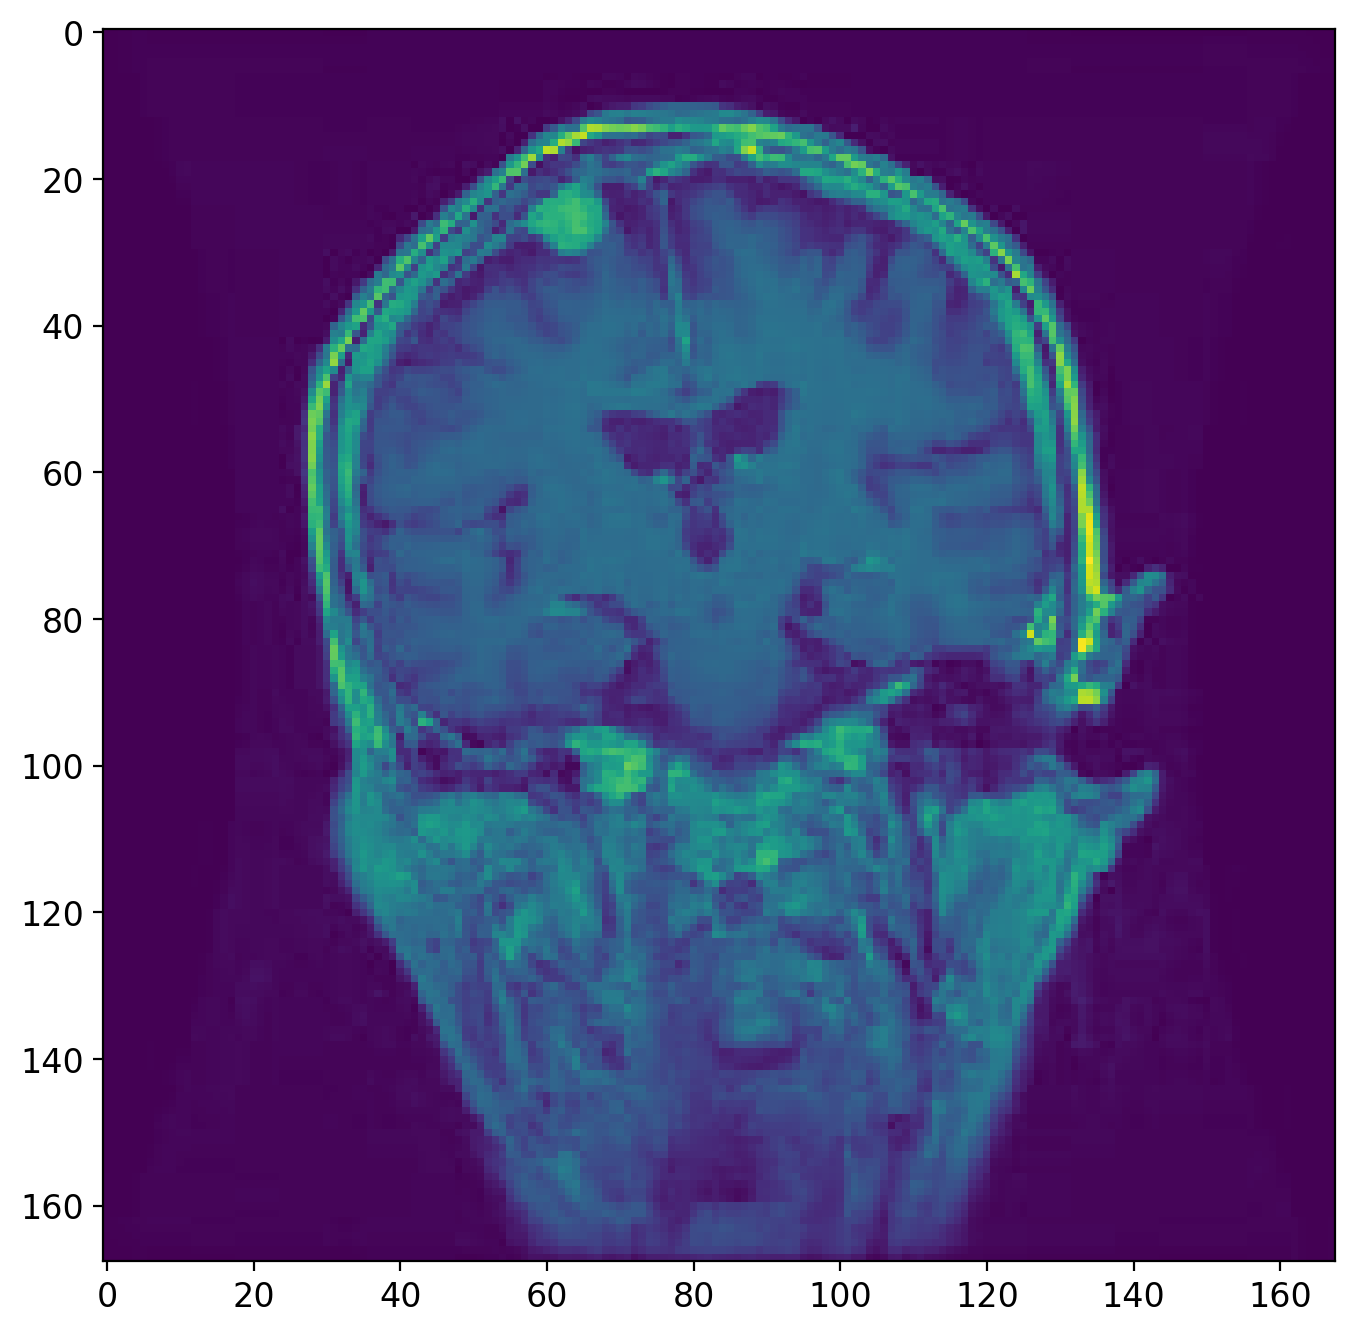

In [141]:
plt.imshow(image)
plt.imshow(guided_gradcam, alpha=0.5)